<a href="https://colab.research.google.com/github/Liaons/py6s-correcao-atmosferica/blob/main/py6s_correcao_atmosferica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 Correção Atmosférica com Py6S

📌 Este material foi elaborado com base na aula ministrada pelos instrutores **Rejane Paulino**, **Daniel Maciel** e **Natália Rudorff**, durante a disciplina **Princípios Físicos**, no curso de pós-graduação em Sensoriamento Remoto do **INPE** (Instituto Nacional de Pesquisas Espaciais).

## 📘 Conteúdo

- ✨ Conceitos fundamentais de correção atmosférica.
- 🛰️ Introdução ao modelo 6S.
- 🧪 Utilização da biblioteca Py6S para simulação atmosférica.
- 📉 Conversão de reflectância no topo da atmosfera (TOA) para reflectância de superfície.
- 💻 Exemplos com código Python e aplicação com parâmetros reais.

⚠️ Importante: O Py6S depende do executável do modelo 6S, que precisa ser instalado separadamente.

---
Versão adaptada para Colab por **Henrique Leão** \
Doutorando em Sensoriamento Remoto - INPE \
GitHub: @Liaons
[Repositório no GitHub](https://github.com/Liaons/py6s-correcao-atmosferica)

# Montando o ambiente Py6s

In [1]:
# Montando o ambiente ()
!pip install py6s -q
!apt install gfortran libgfortran5 -q
!wget https://anaconda.org/conda-forge/sixs/1.1.3/download/linux-64/sixs-1.1.3-h2cc385e_2.tar.bz2 -q
!tar -xvf sixs-1.1.3-h2cc385e_2.tar.bz2
!rm sixs-1.1.3-h2cc385e_2.tar.bz2
!chmod +x bin/sixs
!ln bin/sixs /usr/local/bin/sixs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 3.1 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
gfortran is already the newest version (4:11.2.0-1ubuntu1).
libgfortran5 is already the newest version (12.3.0-1ubuntu1~22.04).
libgfortran5 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
info/files
info/paths.json
info/hash_input.json
info/index.json
info/about.json
info/git
bin/sixs
info/recipe/no_ffpe-summary.patch
info/recipe/meta.yaml.template
info/recipe/conda_build_config.yaml
info/recipe/meta.yaml
info/test/Example_In_1.txt
info/recipe/Example_In_1.txt
info/test/Example_In_3.txt
info/recipe/Example_In_3.txt
info/licenses/LICENSE.md
info/recipe/run_test.sh
info/test/r

In [2]:
# Bibliotecas

from Py6S import *
import numpy as np
import pandas as pd
import glob
from osgeo import gdal
gdal.UseExceptions()
import matplotlib.pyplot as plt
import os

In [4]:
# Baixando as bandas da imagem sentinel para a prática (Essa atividade demora em média 2min)
!mkdir imagem
!wget -O imagem/zenodo_data.zip https://zenodo.org/api/records/15397592/files-archive -q
!unzip imagem/zenodo_data.zip -d imagem

mkdir: cannot create directory ‘imagem’: File exists
Archive:  imagem/zenodo_data.zip
 extracting: imagem/T23KMV_20240430T131239_B02.TIF  
 extracting: imagem/T23KMV_20240430T131239_B09.TIF  
 extracting: imagem/T23KMV_20240430T131239_B04.TIF  
 extracting: imagem/T23KMV_20240430T131239_B05.TIF  
 extracting: imagem/T23KMV_20240430T131239_B06.TIF  
 extracting: imagem/T23KMV_20240430T131239_B10.TIF  
 extracting: imagem/T23KMV_20240430T131239_B11.TIF  
 extracting: imagem/MTD_MSIL1C.xml   
 extracting: imagem/T23KMV_20240430T131239_B8A.TIF  
 extracting: imagem/T23KMV_20240430T131239_B03.TIF  
 extracting: imagem/T23KMV_20240430T131239_TCI.jp2  
 extracting: imagem/T23KMV_20240430T131239_B12.TIF  
 extracting: imagem/T23KMV_20240430T131239_B08.TIF  
 extracting: imagem/T23KMV_20240430T131239_B01.TIF  
 extracting: imagem/MTD_TL.xml       
 extracting: imagem/T23KMV_20240430T131239_B07.TIF  


# Correção atmosférica

In [5]:
# Variaveis de Entrada:
# Para acessar as variáveis de entrada da sua área, sigo o tutorial do link:
# https://github.com/Liaons/py6s-correcao-atmosferica/blob/main/parametros_atmosfericos-GEE.pdf

# Atmosfera + alvo:
AOD550 = 0.144 # Medida adquirida de satélite, MODIS
Altitude = 0.74 # km

# Imagem:
dia = 30
mes = 4
Geometria_solar_AZ = 38.2830765110842
Geometria_solar_Zn = 41.8757812678998
Geometria_sensor_AZ = 101.5
Geometria_sensor_Zn = 6.03

In [6]:
# Com o 6SV:
# Define a classe SixS() -> classe principal do 6SV, ela permite a config. de paramteros, executar e acessar as saidas do 6SV:

s = SixS()

In [7]:
# Definindo os parametros do 6SV:

# Perfil atmosferico:
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)

# Tipos pre-definidos: Sub-Arctic Winter, Mid-Latitude Winte, U.S. Standart, Sub-Arctic Summer, Mid-Latitude Summer, Tropical
# Esses modelos sao padroes derivados do MODITRAN (http://modtran.spectral.com/static/modtran6/html/help_atmosphere_model.html?v=3)
# Escolher um desses parametros significa definifir os valores de vapor d'agua e temperatura do ar esperados para a imagem.

#s.atmos_profile = py6s.AtmosProfile.UserWaterAndOzone(water_vapour, ozone)

In [8]:
# Carga optica do aerossol and Perfil/Modelo do aerossol:

s.aot550 = AOD550
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental) # relativo a distribuicao e composicao fisico-quimica do aerosol na atmosfera;

# Tipos de modelos predefinidos: Continental, Maritime, Urban, Desert, Biomass, Stratospheric.
# s.aero_profile = AeroProfile.User(soot = 0.1, water = 0.3, oceanic = 0.05, dust = 0.55) # baseado na mistura de quatro components: dust, oceanic, water-soluble, and soot.

In [9]:
# Geometrias de iluminacao (solar) e visada (sensor):

s.geometry = Geometry.User()
s.geometry.day = dia
s.geometry.month = mes
s.geometry.solar_z = Geometria_solar_Zn
s.geometry.solar_a = Geometria_solar_AZ
s.geometry.view_z = Geometria_sensor_Zn
s.geometry.view_a = Geometria_sensor_AZ

In [10]:
# Altitude:

s.altitudes = Altitudes()
s.altitudes.set_sensor_satellite_level()  # nivel do sensor;
s.altitudes.set_target_custom_altitude(Altitude)  # nivel do alvo (em km).

In [11]:
# Configurar os comprimentos de ondas das bandas espectrais:

# Interpolacao da Funcao de Resposta Espectral:
def interpolar_bandas(rsr, band_number: int, range_w: list) -> dict:
    output = {}
    bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
    for i in range(1, band_number + 1):
        filter_ = rsr.loc[rsr['id'] == i]
        w_min_ = np.min(filter_['wavelength'])
        w_max_ = np.max(filter_['wavelength'])
        wavelength_ = [np.around(w, 3) for w in np.arange(w_min_, w_max_, 0.001)]
        wavelength_int = [np.around(w, 3) for w in np.arange(range_w[0], range_w[1], 0.001)]
        wavelength_sub = list(set(wavelength_int) - set(wavelength_))
        df_ = pd.DataFrame({'wavelength': wavelength_sub, 'rsr': int(0), 'band': str(i)})
        df_ = pd.concat([filter_, df_]).sort_values(by=['wavelength'], ascending=True)
        d_select = df_['rsr'].to_list()
        wavelength_interp = [np.around(w, 4) for w in np.arange(range_w[0], range_w[1], 0.0025)]
        norm = np.interp(wavelength_interp, df_['wavelength'].to_list(), d_select).tolist()
        out_ = [norm, [i for i in wavelength_interp]]
        output[bands[i - 1]] = out_
    return output

url = "https://raw.githubusercontent.com/Liaons/py6s-correcao-atmosferica/main/rsr_S2B_MSI.txt"
rsr = pd.read_csv(url, sep='\t', skiprows=5, names=['wavelength', 'rsr', 'band', 'id'])

bandas = interpolar_bandas(rsr, 13, [0.411, 2.383])

In [12]:
# Modelagem atmosferica com o 6SV:
atm_parametros = {}

for i in ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']:
    s.wavelength = Wavelength(np.min(bandas[i][1]), np.max(bandas[i][1]), bandas[i][0]) # min comprimento de onda, max comp.onda, rsr (2.5 nm).
    s.run()
    atm_parametros[i] = {'tg_OG_co': float(s.outputs.transmittance_co.total),
                         'tg_OG_c02': float(s.outputs.transmittance_co2.total),
                         'tg_OG_o2': float(s.outputs.transmittance_oxygen.total),
                         'tg_OG_no2': float(s.outputs.transmittance_no2.total),
                         'tg_OG_ch4': float(s.outputs.transmittance_ch4.total),
                         'Tg_O3': float(s.outputs.transmittance_ozone.total),
                         'Tg_H20': float(s.outputs.transmittance_water.total),
                         'T_upward': float(s.outputs.transmittance_total_scattering.upward),
                         'T_downward': float(s.outputs.transmittance_total_scattering.downward),
                         'p_atm': float(s.outputs.atmospheric_intrinsic_reflectance),
                         's': float(s.outputs.spherical_albedo.total)}

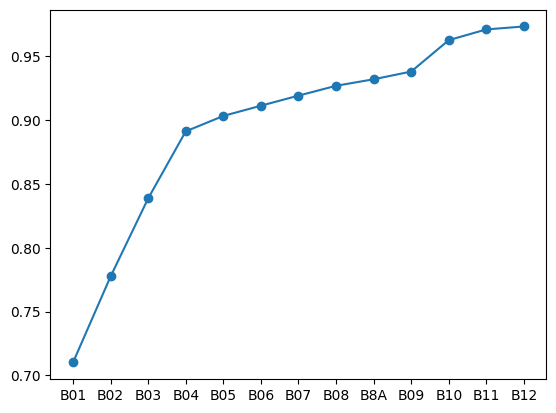

In [13]:
# Transmitancias:

transm = []
#atm = []
for i in ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']:
    transm.append(atm_parametros[i]['T_upward'] * atm_parametros[i]['T_downward'])
    #atm.append(atm_parametros[i]['p_atm'])

plt.plot(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12'], transm, marker='o', linestyle='-')
#plt.plot(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12'], atm, marker='o', linestyle='-')

In [14]:
# Correcao atmosferica:

def abrir_imagem(path: str):
    dataset = gdal.Open(path)
    return dataset.ReadAsArray().astype(float)

def salvar_imagem(array: float, index: str, reference: str, dest: str) -> None:

    filename_reference = reference
    filename_out_factor = dest + '/' + index[0:-4] + '.TIF'
    dataset_reference = gdal.Open(filename_reference)

    line = dataset_reference.RasterYSize
    column = dataset_reference.RasterXSize
    bands = 1

    driver = gdal.GetDriverByName('GTiff')
    data_type = gdal.GetDataTypeByName('Float32')
    dataset_output = driver.Create(filename_out_factor, column, line, bands, data_type)
    dataset_output.SetGeoTransform(dataset_reference.GetGeoTransform())
    dataset_output.SetProjection(dataset_reference.GetProjectionRef())
    dataset_output.GetRasterBand(1).WriteArray(array)
    dataset_output=None
    return None

#Baixar imagem do zenodo e definir a pasta baixada como diretório
dir_img = r'/content/imagem'
os.makedirs('imagem_corrigida', exist_ok=True)

for banda in atm_parametros:
    img_id = [i for i in os.listdir(dir_img) if banda in i][0]
    caminho_img = dir_img + '/' + img_id

    # Conversao de DN para reflectancia TOA:
    # Abrir imagens:
    array = abrir_imagem(caminho_img)
    QUANTIFICATION_VALUE = 10000
    RADIO_ADD_OFFSET = -1000
    ref_toa = (array + RADIO_ADD_OFFSET) / QUANTIFICATION_VALUE

    # Correcao atmosferica -- Equacao de transferecia radiativa:
    Tatm = atm_parametros[banda]['T_upward'] * atm_parametros[banda]['T_downward']
    Tg = atm_parametros[banda]['tg_OG_co'] * atm_parametros[banda]['tg_OG_c02'] * atm_parametros[banda]['tg_OG_o2'] * atm_parametros[banda]['tg_OG_no2'] * atm_parametros[banda]['tg_OG_ch4']
    Tg_O3 = atm_parametros[banda]['Tg_O3']
    Tg_H20 = atm_parametros[banda]['Tg_H20']
    p_atm = atm_parametros[banda]['p_atm']
    s = atm_parametros[banda]['s']

    A = ((ref_toa / (Tg * Tg_O3)) - p_atm) / (Tatm * Tg_H20)
    ref_sup = A / (1 - (A * s))

    salvar_imagem(ref_sup, img_id, caminho_img, r'imagem_corrigida')

# https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-1c/algorithm-overview#:~:text=Before%20storage%20inside%20L1C%20(in,computed%20TOA%20reflectance%20(%CF%81).&text=The%20L1C%20product's%20metadata%20includes,defined%20as%20a%20negative%20value.

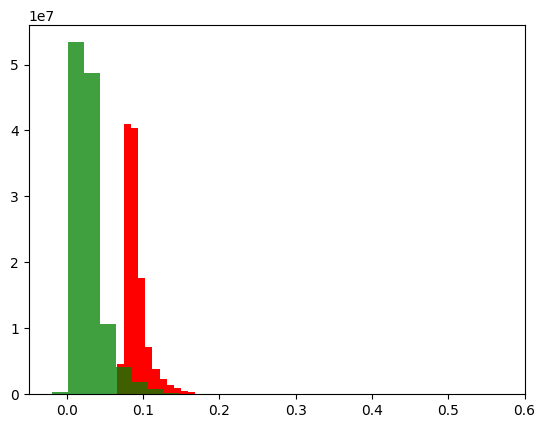

In [18]:
band = "B02"

# Plotando o histograma das imagens:
r_toa = abrir_imagem(f'/content/imagem/T23KMV_20240430T131239_{band}.TIF')
r_toa = (r_toa + (-1000)) / 10000
r_surperficie = abrir_imagem(f'/content/imagem_corrigida/T23KMV_20240430T131239_{band}.TIF')

plt.hist(r_toa.flatten(), bins=250, color='red', edgecolor=None)
plt.hist(r_surperficie.flatten(), bins=250, color='green', edgecolor=None, alpha=0.75)
plt.xlim(-0.05, 0.6)
plt.show()

# Verde os valores da imagem corrigida
# Vermelho do imagem não corrigida